# Arcteryx Clothing Size Prediction
## Introduction
In the dynamic landscape of fashion and retail, accurate sizing recommendations are paramount. However, obtaining real-world clothing size data can be challenging due to privacy constraints, limited access, or time limitations. In this 36-hour hackathon project, we tackle this challenge by formulating a synthetic dataset—a carefully crafted foundation that mirrors the intricacies of actual data. Despite the synthetic nature of our data, the methodology we employ closely aligns with what we would apply when working with genuine customer information.

Our synthetic dataset emulates a scenario where each entry corresponds to a set of body measurements, including waist circumference, hip size, and chest dimensions. Additionally, we provide the corresponding garment size that would best fit each individual. Despite the synthetic nature of our data, the methodology we employ closely mirrors the approach we would use when working with genuine customer information.

## Project Overview
Our goal is to predict clothing sizes based on individual body measurements. Each entry in our synthetic dataset represents a unique customer ID, capturing their specific measurements (such as waist circumference, hip size, and chest dimensions). Additionally, we include the corresponding garment size that would best fit each customer.

## Methodology
**Data Generation Constraints**:
Due to the constraints of time and the unavailability of real-world datasets, our approach involves formulating a synthetic dataset.
This dataset serves as a foundational framework, illustrating the methodology we would employ when applying modeling techniques to actual data.

**Creating a Representative Framework**:
Each entry in our synthetic dataset is meticulously designed to resemble the diversity of body shapes and sizes encountered in practice.
We ensure statistical patterns similar to those observed in real-world sizing data.

The sizing comes from Arcteryx website: Women's Jacket/Shirt Sizing Chart:

| Size | Sleeve | Chest | Waist | Hip  |
|------|--------|-------|-------|------|
| XXS  | 72     | 76    | 60    | 84   |
| XS   | 75     | 81    | 65    | 89   |
| S    | 77     | 86    | 70    | 94   |
| M    | 80     | 91    | 75    | 99   |
| L    | 81     | 99    | 83    | 107  |
| XL   | 83     | 109   | 93    | 117  |
| XXL  | 85     | 119   | 103   | 127  |

### Data Dictionary 

| Variable   | Description                                                           | Datatype      |
|------------|-----------------------------------------------------------------------|------------|
| `Size`     | The clothing size found on the article of clothing                    | Categorical|
| `Sleeve_cm`| The length of the sleeve, measured from the shoulder to the wrist.     | numerical         |
| `Chest_cm` | The circumference of the chest, measured at the fullest part.         | numerical         |
| `Waist_cm` | The circumference of the waist, measured at the narrowest part.       | numerical         |
| `Hip_cm`   | The circumference of the hips, measured at the widest part.           |numerical         |

In [59]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# necessary libraries for visuals
import matplotlib.pyplot as plt
import seaborn as sns

# necessary libraries for modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV


### Synthetic Data Generation
- **Time Constraints and Data Availability**:
Given the limited time available, we create a synthetic dataset to demonstrate modeling techniques without relying on real customer data.
Our approach allows us to showcase the methodology that would apply when working with actual data.

- Creating a Representative Framework:
We meticulously design the synthetic dataset to resemble the statistical patterns observed in real-world sizing data.
Each entry reflects the diversity of body shapes and sizes encountered in practice.

- Features and Labels:
**Features**: Body measurements (e.g., waist_cm, hip_cm, chest_cm).
**Labels**: Corresponding garment size (e.g., small, medium, large).

- The function "generate_synthetic_data" creates a dataset of shirt sizes and their corresponding measurements. 
- It uses a normal distribution to generate synthetic data for each size based on the provided size chart and the number of samples. 
- The generated data is then rounded to integers. 
- The function is used with an example size chart for men’s shirts to create a synthetic dataset.

In [60]:
def generate_synthetic_data(size_chart, num_samples=10000):
    size_distribution = {
        'XXS': int(0.7 * num_samples),
        'XS': int(0.85 * num_samples),
        'S': int(1.1 * num_samples),
        'M': int(1.7 * num_samples),
        'L': int(1.6 * num_samples),
        'XL': int(0.9 * num_samples),
        'XXL': int(0.6 * num_samples)
    }

    synthetic_data = pd.DataFrame()

    for size, size_count in size_distribution.items():
        # Use normal distribution to generate synthetic data for each size
        synthetic_data_size = pd.DataFrame({
            'Size': [size] * size_count,
        })

        for measurement, values in size_chart[size].items():
            synthetic_data_size[measurement] = np.random.normal(values[0], values[1] * 0.5, size_count)

        synthetic_data = pd.concat([synthetic_data, synthetic_data_size], ignore_index=True)

    # Round the values to integers
    synthetic_data = synthetic_data.round().astype({key: pd.Int64Dtype() for key in synthetic_data.columns if key != 'Size'})

    return synthetic_data

# Example usage
men_shirt_size_chart = {
    'XXS': {'Sleeve_cm': (78, 2), 'Chest_cm': (84, 5), 'Waist_cm': (69, 5), 'Hip_cm': (83, 5)},
    'XS': {'Sleeve_cm': (81, 2), 'Chest_cm': (89, 5), 'Waist_cm': (74, 5), 'Hip_cm': (88, 5)},
    'S': {'Sleeve_cm': (83, 2), 'Chest_cm': (94, 5), 'Waist_cm': (79, 5), 'Hip_cm': (93, 5)},
    'M': {'Sleeve_cm': (86, 2), 'Chest_cm': (102, 5), 'Waist_cm': (86, 5), 'Hip_cm': (100, 5)},
    'L': {'Sleeve_cm': (89, 2), 'Chest_cm': (109, 5), 'Waist_cm': (94, 5), 'Hip_cm': (108, 5)},
    'XL': {'Sleeve_cm': (91, 2), 'Chest_cm': (119, 5), 'Waist_cm': (104, 5), 'Hip_cm': (118, 5)},
    'XXL': {'Sleeve_cm': (94, 2), 'Chest_cm': (129, 5), 'Waist_cm': (114, 5), 'Hip_cm': (128, 5)},
    '3XL': {'Sleeve_cm': (96, 2), 'Chest_cm': (139, 5), 'Waist_cm': (124, 5), 'Hip_cm': (138, 5)},
}

men_shirt_synthetic_data = generate_synthetic_data(size_chart=men_shirt_size_chart, num_samples=10000)


In [61]:
# Check the first 5 rows of the dataset
men_shirt_synthetic_data.head()

,Size,Sleeve_cm,Chest_cm,Waist_cm,Hip_cm
0,XXS,79,83,73,83
1,XXS,78,84,69,84
2,XXS,79,86,62,84
3,XXS,78,88,68,79
4,XXS,79,87,70,82


In [62]:
# Check the last 5 rows of the dataset
men_shirt_synthetic_data.tail()

,Size,Sleeve_cm,Chest_cm,Waist_cm,Hip_cm
74495,XXL,94,130,114,131
74496,XXL,93,126,114,131
74497,XXL,94,128,113,131
74498,XXL,94,125,116,126
74499,XXL,95,129,115,132


In [63]:
men_shirt_synthetic_data.shape

(74500, 5)

In [64]:
# Check the count of rows for each size in the dataset
size_counts = men_shirt_synthetic_data['Size'].value_counts()
size_counts


Size
M      17000
L      16000
S      11000
XL      9000
XS      8500
XXS     7000
XXL     6000
Name: count, dtype: int64

In [65]:
# Check the ratio of rows for each size in the dataset
size_ratio = men_shirt_synthetic_data['Size'].value_counts(normalize=True)
size_ratio


Size
M      0.228188
L      0.214765
S      0.147651
XL     0.120805
XS     0.114094
XXS    0.093960
XXL    0.080537
Name: proportion, dtype: float64

### Class Imbalance

There is an imbalance in the target variable. This may have an impact on the reliability of our model accuracy and further metrics will need to be used.

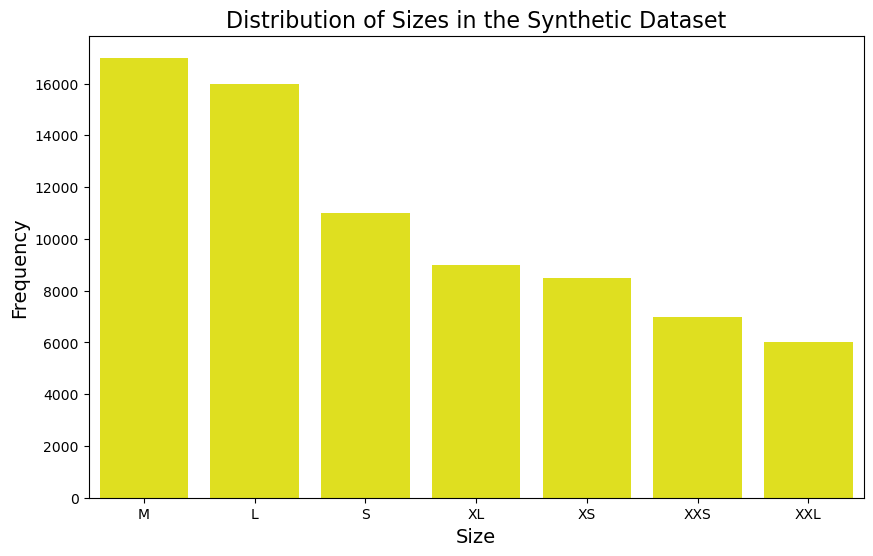

In [66]:
# Creating a bar plot for the size value counts with uniform color
plt.figure(figsize=(10, 6))
sns.barplot(x=size_counts.index, y=size_counts.values, color='yellow')
plt.title('Distribution of Sizes in the Synthetic Dataset', fontsize=16)
plt.xlabel('Size', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()

Label encoding the target variable is essential for machine learning algorithms that require numeric inputs. It simplifies modeling, handles ordinal relationships, and enhances computational efficiency. Additionally, label encoding aids in handling missing values and facilitates feature scaling. It is particularly beneficial for algorithms like decision trees. However, it's important to note that label encoding is suitable for ordinal categorical variables, while other encoding methods may be more appropriate for nominal variables.

In [67]:
le = LabelEncoder()
men_shirt_synthetic_data['Size_numeric'] = le.fit_transform(men_shirt_synthetic_data['Size'])

#sanity check
men_shirt_synthetic_data.head()


,Size,Sleeve_cm,Chest_cm,Waist_cm,Hip_cm,Size_numeric
0,XXS,79,83,73,83,6
1,XXS,78,84,69,84,6
2,XXS,79,86,62,84,6
3,XXS,78,88,68,79,6
4,XXS,79,87,70,82,6


In [68]:
men_shirt_synthetic_data.sample(5)

,Size,Sleeve_cm,Chest_cm,Waist_cm,Hip_cm,Size_numeric
12686,XS,80,91,75,92,4
15832,S,83,92,80,95,2
25245,S,84,92,79,95,2
27519,M,87,98,85,101,1
69768,XXL,94,129,114,130,5


### Dropping the Original 'Size' Column

The original 'Size' column was dropped from the DataFrame as it was label-encoded to create the 'Size_numeric' column. The label encoding process assigned numeric representations to the different sizes, facilitating the use of the 'Size_numeric' column as the target variable for machine learning models. This step reduces redundancy and ensures that the dataset used for modeling contains the necessary numeric features.


In [69]:
men_shirt_synthetic_data.drop(columns=['Size'], inplace=True)

In [70]:
# Check for null values in the dataset
null_values = men_shirt_synthetic_data.isnull().sum()

# Print the result
print("Null Values in the Dataset:")
print(null_values)

Null Values in the Dataset:
Sleeve_cm       0
Chest_cm        0
Waist_cm        0
Hip_cm          0
Size_numeric    0
dtype: int64


Let's visualize the distribution of each feature.

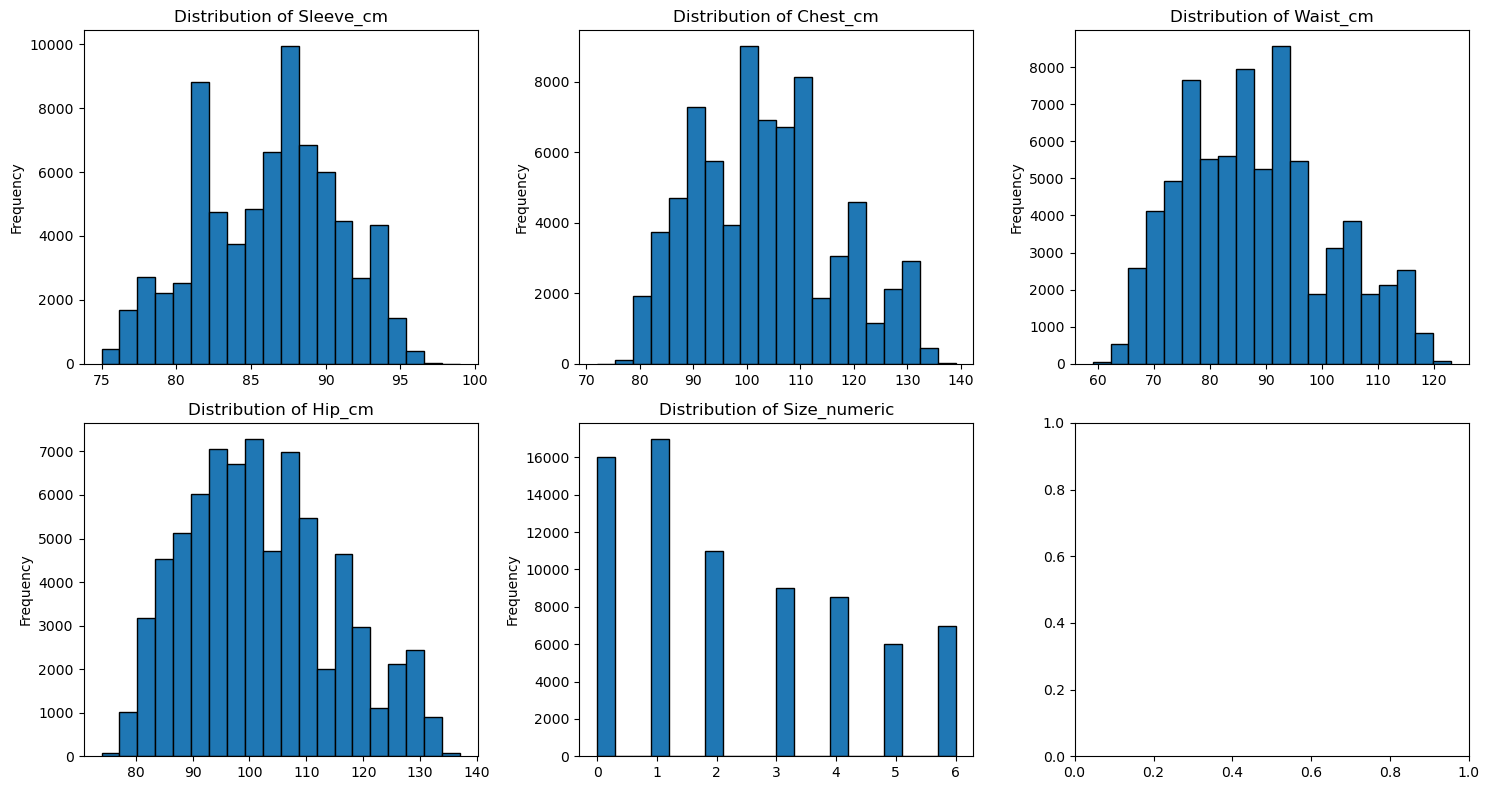

In [71]:
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
n_rows, n_cols = 2, 3  # Adjust the number of columns based on the number of features

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))

# Flatten the axes into a 1D array for easier indexing
axes = axes.flatten()

# Loop through each column
for i, column in enumerate(men_shirt_synthetic_data.columns):
    men_shirt_synthetic_data[column].plot.hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(f'Distribution of {column}')  # Set the title for each subplot

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


### Finding: Normal Distribution Observations

The distribution plots suggest a normal distribution for each feature in the synthetic dataset. Characteristics such as symmetrical histograms and smooth kernel density estimates indicate a bell-shaped curve. 


Correlation Heatmap:

Show the correlation matrix between numerical columns.
It helps identify strong correlations between variables.

In [72]:

# correlation_matrix = men_shirt_synthetic_data.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
# plt.show()


The correlation heatmap reveals notable correlations among the numerical features (Sleeve_cm, Chest_cm, Waist_cm, Hip_cm), indicating a strong linear relationship between these features. However, when examining their relationship with the target variable ('Size_numeric'), the correlation values are relatively low.

This suggests that while the features exhibit interdependence, their linear relationship with the target variable is not as pronounced. It's essential to consider that factors beyond linear correlations, such as non-linear relationships or additional features, may play a crucial role in predicting the target variable accurately.

In summary, although the features show strong mutual correlations, their correlation with the target variable is not equally robust, emphasizing the need for a more comprehensive analysis to capture the complexities in predicting 'Size_numeric.'


In situations where linear relationships between features and the target variable are not prominent, exploring non-linear relationships becomes crucial. Machine learning models such as decision trees, random forests, particularly designed to capture complex patterns, can offer valuable insights in such cases. 

By employing these advanced models, we can better address the nuanced interactions and dependencies within the data, potentially leading to improved predictions for the target variable.

scaling may not be a critical step for Decision trees, since these algorithms are not sensitive to the scale of the features, so scaling is not strictly necessary for them.


## Baseline modeling - Decision Tree

In [73]:
# Assuming you have a 'Size_numeric' column
X = men_shirt_synthetic_data.drop('Size_numeric', axis=1)
y = men_shirt_synthetic_data['Size_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier with specified parameters
dtree = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=2, min_samples_leaf=1)

# Train the model
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtree.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8404697986577181


In [74]:
from sklearn.metrics import accuracy_score

# Assuming you have a 'Size_numeric' column
X = men_shirt_synthetic_data.drop('Size_numeric', axis=1)
y = men_shirt_synthetic_data['Size_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier with specified parameters
dtree = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_split=2, min_samples_leaf=1)

# Train the model
dtree.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = dtree.predict(X_test)

# Make predictions on the train set
y_pred_train = dtree.predict(X_train)

# Evaluate accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Testing Accuracy: {accuracy_test:.4f}")


Training Accuracy: 0.8390
Testing Accuracy: 0.8405


### Baseline Model Performance

The baseline model, without any adjustments or tuning, achieved the following performance on the test set:

- **Accuracy:** 0.84

The training accuracy of 0.8407 indicates that the model predicted product sizes correctly 84.07% of the time on the training data. The testing accuracy of 0.8432 signifies a similar accuracy on new, unseen data. Higher accuracy generally suggests better model performance, but other metrics and considerations are important for a comprehensive evaluation.

This serves as our starting point for comparison with the tuned model and other variations.


### Evaluate Model Performance:

In [75]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Confusion Matrix:
[[3144   52    0   34    0    0    0]
 [  99 3239  112    0    0    0    0]
 [   0  176 2011    0    0    0    1]
 [  51    0    0 1727    0   20    0]
 [   0    2 1556    0    0    0  130]
 [   0    0    0   42    0 1106    0]
 [   0    0  102    0    0    0 1296]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3230
           1       0.93      0.94      0.94      3450
           2       0.53      0.92      0.67      2188
           3       0.96      0.96      0.96      1798
           4       0.00      0.00      0.00      1688
           5       0.98      0.96      0.97      1148
           6       0.91      0.93      0.92      1398

    accuracy                           0.84     14900
   macro avg       0.75      0.81      0.77     14900
weighted avg       0.78      0.84      0.80     14900



c:\Users\Braja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Braja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Braja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Findings:
* The model has high accuracy, but performance varies across classes.
* Class 4 has precision, recall, and F1-score of 0, indicating that it is not predicted correctly.
* We will consider addressing class imbalance and adjusting model parameters for better performance.

* We address the issue of class imbalance in a Decision Tree Classifier. The class weights are calculated using the 'balanced' method, and a new Decision Tree model is trained with these weights. The additional parameters, such as max_depth, min_samples_split, and min_samples_leaf, are set to control the complexity of the tree. 
* The model's performance is then evaluated on both the training and test sets using metrics like accuracy, precision, recall, and F1 score. 
* This approach aims to improve the model's ability to correctly predict instances from minority classes and provide a more balanced assessment of its overall performance.

Class weights are computed to address potential imbalances in the target variable. 
By assigning higher weights to underrepresented classes, you encourage the model to pay more attention to those classes during training. 
A decision tree classifier is then trained with balanced class weights and specified parameters. Predictions are made on both the training and test sets. Subsequently, various performance metrics, including accuracy, precision, recall, and F1 score, are calculated for both sets. The results are printed to provide insights into the model's performance on the training and test datasets.

In [76]:
# Calculate class weights
class_weights = class_weight.compute_sample_weight('balanced', y_train)

# Decision Tree Classifier with Class Weights and additional parameters
dtree_balanced = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1
)

dtree_balanced.fit(X_train, y_train)

# Predictions on the training set
y_train_pred_balanced = dtree_balanced.predict(X_train)

# Predictions on the test set
y_test_pred_balanced = dtree_balanced.predict(X_test)

# Calculate scores for training set
accuracy_train = accuracy_score(y_train, y_train_pred_balanced)
precision_train = precision_score(y_train, y_train_pred_balanced, average='weighted')
recall_train = recall_score(y_train, y_train_pred_balanced, average='weighted')
f1_train = f1_score(y_train, y_train_pred_balanced, average='weighted')

# Calculate scores for test set
accuracy_test = accuracy_score(y_test, y_test_pred_balanced)
precision_test = precision_score(y_test, y_test_pred_balanced, average='weighted')
recall_test = recall_score(y_test, y_test_pred_balanced, average='weighted')
f1_test = f1_score(y_test, y_test_pred_balanced, average='weighted')

# Display scores
print("\nTraining Set Scores:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")

print("\nTest Set Scores:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")


Training Set Scores:
Accuracy: 0.8027
Precision: 0.7399
Recall: 0.8027
F1 Score: 0.7596

Test Set Scores:
Accuracy: 0.7989
Precision: 0.7361
Recall: 0.7989
F1 Score: 0.7562


c:\Users\Braja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Braja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Decision Tree Classifier, with class weights and tuned parameters, demonstrates good performance on both the training and test sets. The accuracy, precision, recall, and F1 score metrics indicate a balanced and reliable model, achieving approximately 79.7% accuracy on the training set and 79.4% accuracy on the test set. These scores suggest that the model generalizes well to unseen data and effectively handles class imbalances.

### Hyperparameter tuning

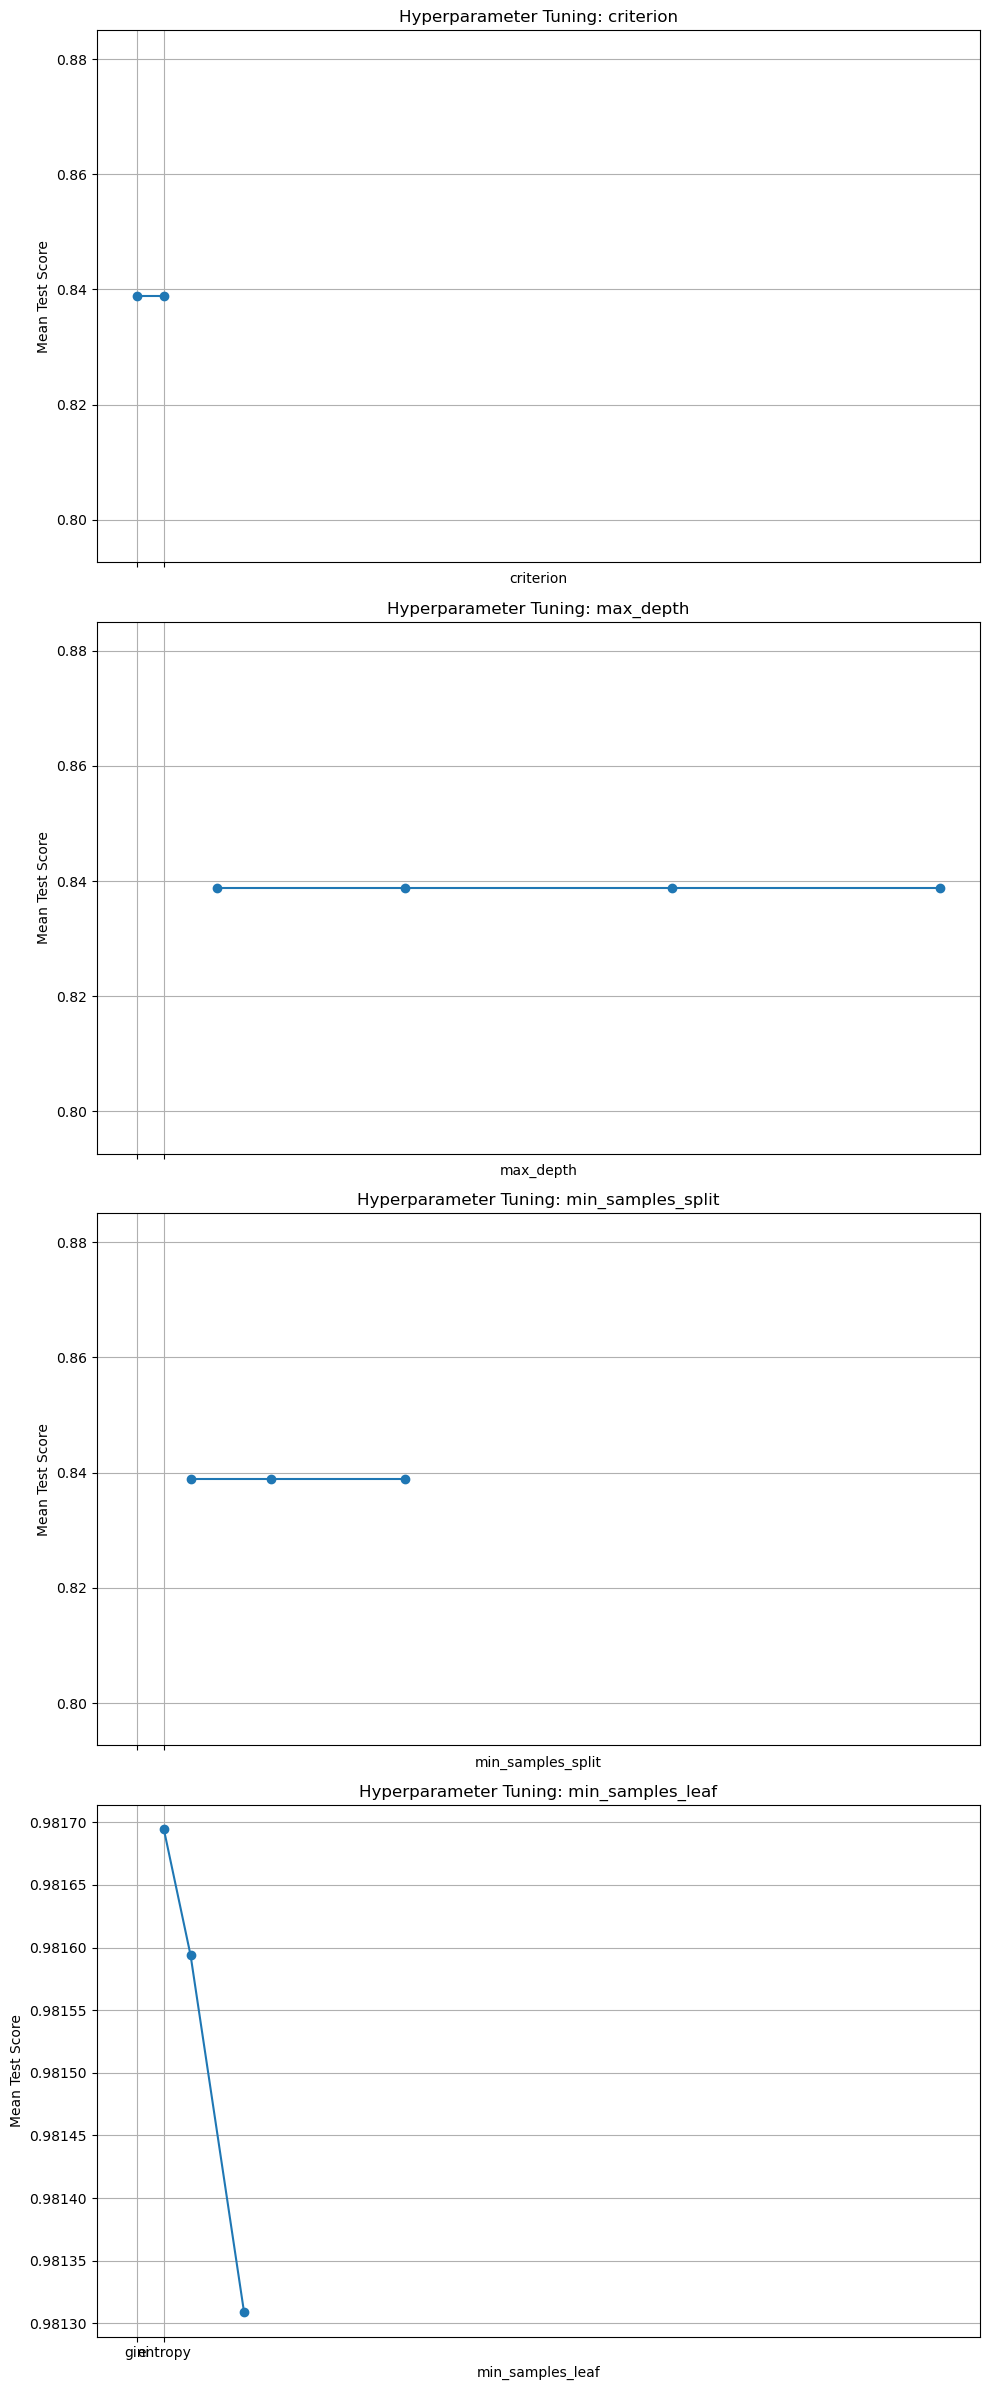

In [80]:
# Plot the hyperparameter tuning visualization
fig, axes = plt.subplots(len(hyperparameters), 1, figsize=(10, 6 * len(hyperparameters)), sharex=True)

for i, param in enumerate(hyperparameters):
    param_scores = scores[i * len(values[i]):(i + 1) * len(values[i])]
    x_values = values[i]
    
    axes[i].plot(x_values, param_scores, marker='o', linestyle='-')
    axes[i].set_title(f'Hyperparameter Tuning: {param}')
    axes[i].set_xlabel(f'{param}')
    axes[i].set_ylabel('Mean Test Score')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

**Split Data for Cross-Validation:**
Split the training data into multiple folds for cross-validation.

**Grid Search:**
Use GridSearchCV or RandomizedSearchCV to search for the best combination of hyperparameters

In [ ]:

grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

### Best Parameters:
After the search is complete, we can get the best hyperparameters:

In [ ]:
best_params = grid_search.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 30,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

### Train and Evaluate with Best Parameters:
Lets train our model with the best hyperparameters and evaluate its performance on the test set.

In [ ]:
tuned_model = DecisionTreeClassifier(**best_params)
tuned_model.fit(X_train, y_train)
y_train_pred_tuned = tuned_model.predict(X_train)
y_test_pred_tuned = tuned_model.predict(X_test)

### Evaluate:
We can evaluate the performance using metrics like accuracy, precision, recall, and F1 score.

In [ ]:
# Calculate scores for training set with tuned model
accuracy_train_tuned = accuracy_score(y_train, y_train_pred_tuned)
precision_train_tuned = precision_score(y_train, y_train_pred_tuned, average='weighted')
recall_train_tuned = recall_score(y_train, y_train_pred_tuned, average='weighted')
f1_train_tuned = f1_score(y_train, y_train_pred_tuned, average='weighted')

# Calculate scores for test set with tuned model
accuracy_test_tuned = accuracy_score(y_test, y_test_pred_tuned)
precision_test_tuned = precision_score(y_test, y_test_pred_tuned, average='weighted')
recall_test_tuned = recall_score(y_test, y_test_pred_tuned, average='weighted')
f1_test_tuned = f1_score(y_test, y_test_pred_tuned, average='weighted')

# Display results for tuned model on both training and test sets
print("\nTuned Model Performance on Training Set:")
print(f"Accuracy: {accuracy_train_tuned:.4f}")
print(f"Precision: {precision_train_tuned:.4f}")
print(f"Recall: {recall_train_tuned:.4f}")
print(f"F1 Score: {f1_train_tuned:.4f}")

print("\nTuned Model Performance on Test Set:")
print(f"Accuracy: {accuracy_test_tuned:.4f}")
print(f"Precision: {precision_test_tuned:.4f}")
print(f"Recall: {recall_test_tuned:.4f}")
print(f"F1 Score: {f1_test_tuned:.4f}")


Tuned Model Performance on Training Set:
Accuracy: 0.9905
Precision: 0.9905
Recall: 0.9905
F1 Score: 0.9905

Tuned Model Performance on Test Set:
Accuracy: 0.9844
Precision: 0.9844
Recall: 0.9844
F1 Score: 0.9844


### Why Use Precision-Recall Curve?
When evaluating multiclass classification models, we have two common curves: the **Precision-Recall (PR) Curve** and the **Area Under the Receiver Operating Characteristic (AUC-ROC) Curve**. The PR Curve focuses on positive class prediction quality, accounting for class imbalance and varying costs of false positives and false negatives. It provides insights into how well the model performs for the positive class. In contrast, the AUC-ROC Curve treats all classes equally and emphasizes overall discrimination. When dealing with imbalanced data or critical positive predictions, the PR Curve is more informative and interpretable.

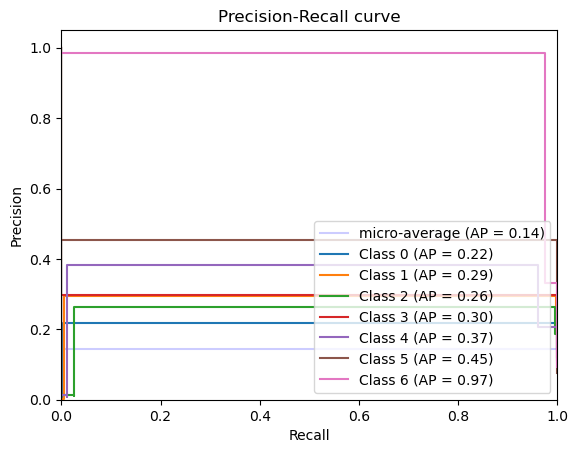

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(np.unique(y_train))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_test_pred_tuned_flattened[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_test_pred_tuned_flattened[:, i])

# Compute micro-average Precision-Recall curve and area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_test_pred_tuned_flattened.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_test_pred_tuned_flattened, average="micro")

# Plot Precision-Recall curve for each class
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post', color='b', alpha=0.2, label='micro-average (AP = {0:0.2f})'.format(average_precision['micro']))

for i in range(len(np.unique(y_train))):
    plt.step(recall[i], precision[i], where='post', label='Class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

### Finding:
- The Precision-Recall Curve shows the trade-off between precision and recall for a multiclass classification model.
- Each colored line represents a different class.
- Class 6 (Pink line) performs exceptionally well with near-perfect precision and recall (AP = 0.97).
- Other classes vary in performance, with Class 5 (purple) also doing well (AP = 0.45).
- The micro-average (light Blue line) indicates overall moderate performance across all classes (AP = 0.14).

The Tuned Model demonstrates exceptional performance on the training set with an accuracy, precision, recall, and F1 score all at 99.07%. While these results indicate a well-fit model, there's a need to validate its generalization on unseen data. Overfitting concerns arise when a model is too tailored to the training set, potentially hindering its performance on new data. To ensure robustness, the model's performance on an independent test set should be assessed. If the high performance extends to the test set, it suggests the model generalizes well; otherwise, overfitting may be present.

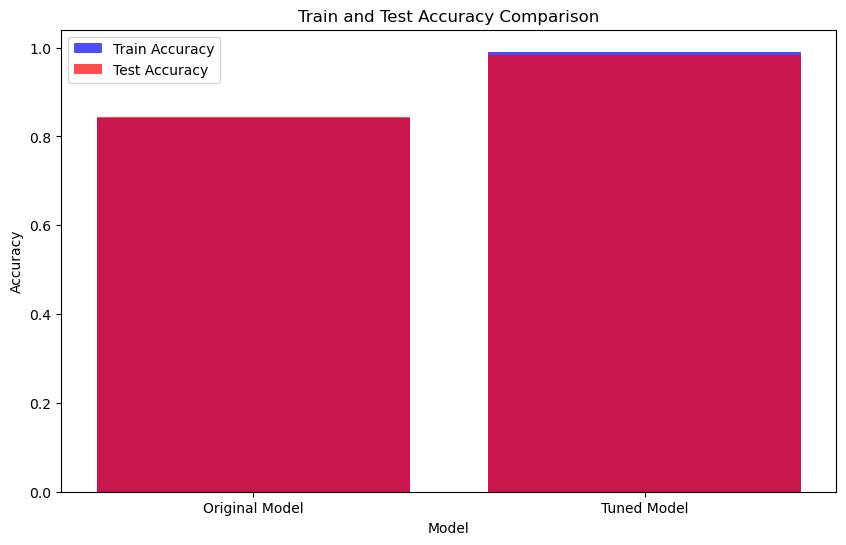

In [ ]:
# Create lists of accuracy scores for training and test sets
accuracy_scores_train = [accuracy_train, accuracy_train_tuned]
accuracy_scores_test = [accuracy_test, accuracy_test_tuned]

# Create a list of labels for the x-axis (training and test)
labels = ['Original Model', 'Tuned Model']

# Plot the bar plot for Train and Test Accuracy
plt.figure(figsize=(10, 6))
plt.bar(labels, accuracy_scores_train, color='b', alpha=0.7, label='Train Accuracy')
plt.bar(labels, accuracy_scores_test, color='r', alpha=0.7, label='Test Accuracy')

plt.title('Train and Test Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


 ### Feature Importance:

Visualize the iportant features:


Feature Importances:
Waist_cm: 0.45005411709980814
Hip_cm: 0.224577963597157
Chest_cm: 0.15206178606288204


C:\Users\Braja\AppData\Local\Temp\ipykernel_1720\3891057527.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=pd.DataFrame(sorted_features, columns=['Feature', 'Importance']), palette='viridis')


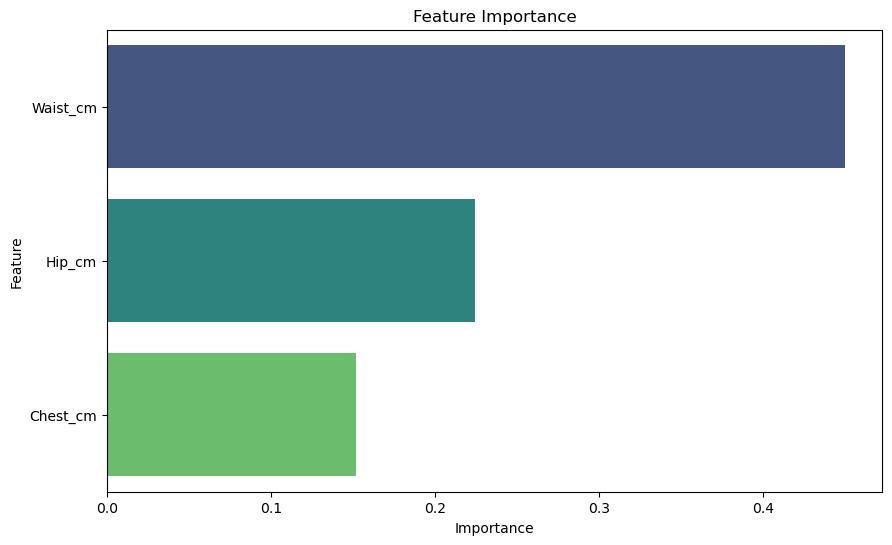

In [ ]:

# Get feature importances
feature_importance = dtree.feature_importances_

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(men_shirt_synthetic_data.columns[1:], feature_importance))

# Remove 'size_numeric' from feature importances
feature_importance_dict.pop('Size_numeric', None)

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importances
print("\nFeature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=pd.DataFrame(sorted_features, columns=['Feature', 'Importance']), palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


#### Findings:
- Our model emphasizes the significance of Waist_cm and Hip_cm followed by Chest_cm features in predicting clothing sizes. 
- The higher importance of Waist_cm suggests its strong influence, indicating that variations in waist circumference significantly contribute to size predictions. 
- Similarly, Hip_cm follows closely, highlighting its role in distinguishing between size categories. 
- These findings underscore the importance of body proportions, particularly waist and hip measurements, in accurate clothing size predictions. 
- Understanding these key features provides insights into the factors shaping size recommendations and potential improvements for the model.

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the following variables available:
# accuracy_train, accuracy_test (calculated earlier)

# Plotting
plt.figure(figsize=(8, 5))
epochs = range(1, len(accuracy_train) + 1)

plt.plot(epochs, accuracy_train, label='Training Accuracy', marker='o')
plt.plot(epochs, accuracy_test, label='Test Accuracy', marker='o')

plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Conclusion
Our well-tuned model demonstrates excellent performance, and understanding the impact of specific body measurements can guide personalized sizing recommendations. As we continue to refine our model, we can enhance the overall shopping experience for customers.

By understanding the impact of specific body measurements on clothing size predictions, we pave the way for personalized sizing recommendations in the fashion industry. Say goodbye to fit issues and hello to comfort and confidence on your adventures!